# Random forest experimentation

In [109]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from rfpimp import *

from sklearn import tree
from dtreeviz.trees import *

import pltvid

def jeremy_trick_RF_sample_size(n):
    # Jeremy's trick
    from sklearn.ensemble import forest
    forest._generate_sample_indices = \
        (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples,n))

In [2]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

## Bagging (Bootstrap aggregation)

In [3]:
def boston():
    boston = load_boston()
    X = boston.data
    y = boston.target
    features = boston.feature_names
    df = pd.DataFrame(data=X,columns=features)
    df['y'] = y
    return df

In [4]:
df_boston = boston()
# X, y = df_boston.drop('y', axis=1), df['y']
#features = X.columns
X, y = df_boston[['LSTAT']], df_boston['y']
features = ['LSTAT']
X.head(3)

,LSTAT
0,4.98
1,9.14
2,4.03


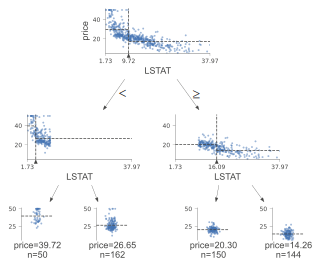

In [5]:
t = DecisionTreeRegressor(max_features=1, max_depth=2, random_state=999)#, min_samples_leaf=80)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

In [6]:
df_boston = df_boston.sample(len(df_boston), replace=True)
# X, y = df_boston.drop('y', axis=1), df['y']
X, y = df_boston[['LSTAT']], df_boston['y']

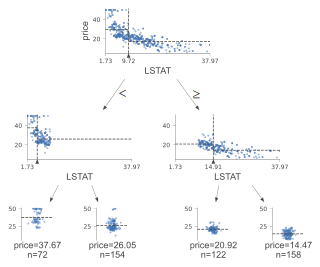

In [7]:
t = DecisionTreeRegressor(max_features=1, max_depth=2, random_state=999)#, min_samples_leaf=80)
# t = DecisionTreeRegressor(max_features=1.0, min_samples_leaf=80)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

## max features to decorrelate

In [8]:
df_boston = boston()
X, y = df_boston.drop('y', axis=1), df_boston['y']
features = X.columns
X.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [9]:
X.shape

(506, 13)

Base tree using all features, not bootstrapping.

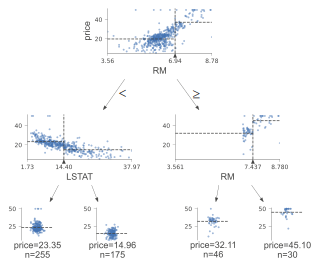

In [10]:
t = DecisionTreeRegressor(max_features=1.0, max_depth=2)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

Now run max_features=5 to see different tree 

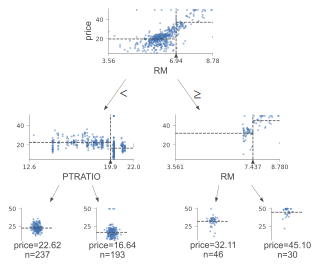

In [11]:
t = DecisionTreeRegressor(max_features=5, max_depth=2)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

Now run again to see different tree 

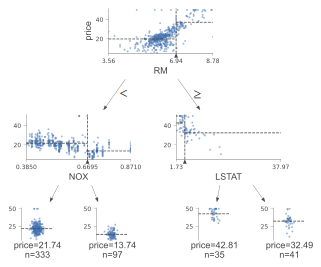

In [12]:
t = DecisionTreeRegressor(max_features=5, max_depth=2)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

## Error vs num trees

In [13]:
def sim_ntrees(X_train, X_test, y_train, y_test,
                max_features = 'auto',
                min_samples_leaf=1,      # lowest bias but increases variance
                ntrials = 5,
              tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50]):

    all_test_scores = np.zeros(shape=(ntrials,len(tree_sizes)))
    for i in range(ntrials):
        print(f" {i}", end='')
        test_scores = []
        for j,n_estimators in enumerate(tree_sizes):
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=True,
                                      n_jobs=-1)
            rf.fit(X_train, y_train)
            s = mean_absolute_error(y_test, rf.predict(X_test))
    #         s = rf.score(X_test, y_test)
            test_scores.append(s)

        all_test_scores[i] = test_scores
        avg = np.mean(test_scores)
        
    return all_test_scores, tree_sizes

### Fixed train/test, effect of num trees

In [14]:
df_rent = pd.read_csv("data/rent-ideal.csv")
X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
y = df_rent['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

#max_features = X_train.shape[1]
max_features = 1
# max_features = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, max_features=max_features)
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1 2 3 4

array([4.00442706, 2.26718961, 0.79766324, 0.94256232, 1.3819475 ,
       2.25450088, 0.88461142, 1.74908365, 0.81517484, 0.85586561,
       0.98718617, 0.34172207])

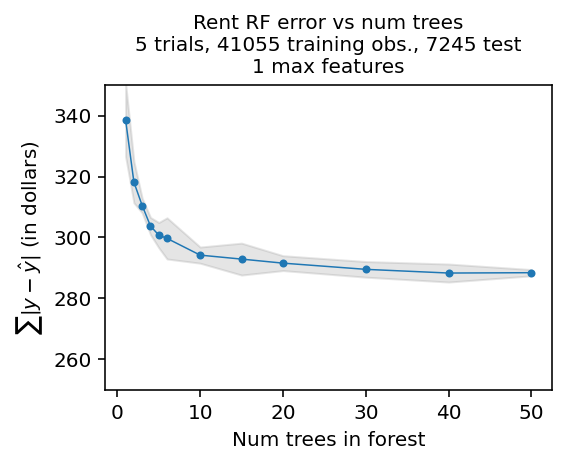

In [15]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

# ax2 = ax.twinx()
# b = ax2.plot(tree_sizes, test_variances*3, lw=1, label="test set MAE $3\sigma$", c='orange')
# ax2.yaxis.label.set_color('orange')
# #ax2.set_ylabel("Test $\sigma$")
# ax2.tick_params(axis='y', colors='orange')
# ax2.set_ylim(-0.002,15.0)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$ (in dollars)")
ax.set_ylim(250,350)
# lines = a+b
# labels = [l.get_label() for l in lines]
# ax.legend(lines,labels,loc='upper right')

#ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==X_train.shape[1]:
    ax.set_title(f"Rent bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features", fontsize=10)
else:
    ax.set_title(f"Rent RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features", fontsize=10)

#### Pick num trees

In [16]:
df_rent = pd.read_csv("data/rent-ideal.csv")
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=20,
                               min_samples_leaf=1,
                               max_features=X.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8527027061984193, 293.6898181209605)

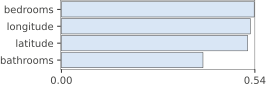

In [17]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### Select max features

In [18]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=20,
                               min_samples_leaf=1,
                               max_features=X.shape[1]-3,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8541530846341796, 293.7829634104993)

Can crank num trees up if you want

In [19]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=100,
                               min_samples_leaf=1,
                               max_features=X.shape[1]-3,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8577212165903397, 289.6637409371614)

## Bulldozer

In [20]:
def bulldozer(basefeatures = ['SalesID',
                    'MachineID', 'ModelID',
                    'datasource', 'YearMade',
                    # some missing values but use anyway:
                    'auctioneerID', 'MachineHoursCurrentMeter']):
    df_bull = pd.read_feather("data/bulldozer-train.feather") # these are sorted by date

    df_bull = df_bull.fillna(0) # flip missing numeric values to zeros

    ntest = 15_000
    df_bull_test = df_bull.iloc[-ntest:] # take only last 100,000 records
    df_bull_train = df_bull.iloc[-(100_000+ntest):-ntest] # train only last 100,000 records

    X_train, y_train = df_bull_train[basefeatures], df_bull_train['SalePrice']
    X_test, y_test = df_bull_test[basefeatures], df_bull_test['SalePrice']

    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = bulldozer()

#max_features = len(X_train.columns)
max_features = len(X_train.columns)-1
min_samples_leaf = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, ntrials=ntrials,
                                         max_features=max_features,
                                         min_samples_leaf=min_samples_leaf,
                                        tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50,100])
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1 2 3 4

array([ 86.97943   , 425.42593504, 121.30550704, 175.04605161,
        65.59592633, 107.09114209,  95.9241484 ,  92.25592482,
        67.9713446 ,  66.96702364,   6.91350717,  43.43889597,
        29.89699936])

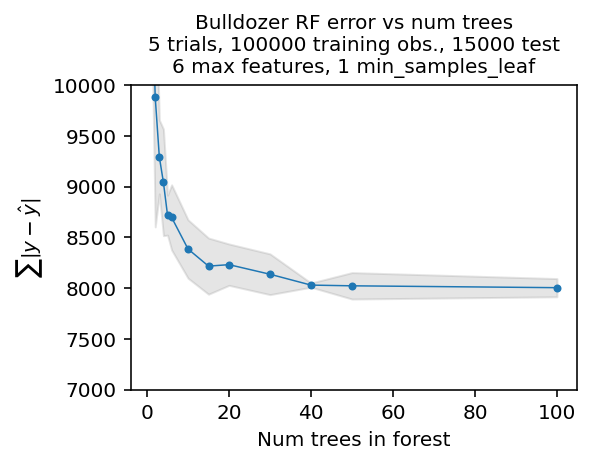

In [22]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$")
ax.set_ylim(7000,10_000)
#ax.legend(loc='upper right')

#ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==len(X_train.columns):
    ax.set_title(f"Bulldozer bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)
else:
    ax.set_title(f"Bulldozer RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)

#### Tuning; find num trees first

In [23]:
X_train, X_test, y_train, y_test = bulldozer()

scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=30,
                               min_samples_leaf=1,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.766559199732385, 7792.221473777778)

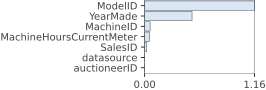

In [24]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### Set min_samples_leaf

(max_features is best at p).

Slight improvement with `min_samples_leaf`=2

In [25]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=30,
                               min_samples_leaf=2,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.7698141766688131, 7686.497347678269)

Now crank num trees

In [26]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=150,
                               min_samples_leaf=2,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.7748262751139381, 7594.177050080592)

## Synthetic quadratic data

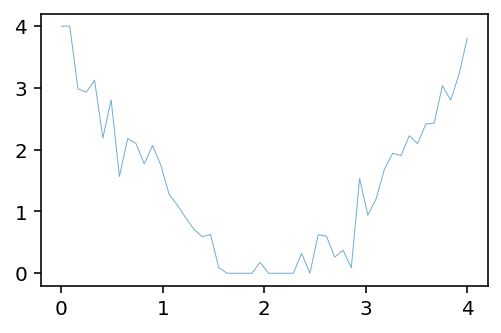

In [260]:
def quad_data(n = 50):
    X = np.linspace(0,4,num=n).reshape(n,1)
    y = (X-2)**2 + np.random.normal(0,.4,n).reshape(n,1)
    y = np.clip(y,0,4) # clip a little bit so that the animation is stable below
    return X,y

X,y = quad_data()
fig,ax = plt.subplots(1,1,figsize=(4,2.5))
# ax.scatter(X,y,s=20,c='#ABD9E9',edgecolors=GREY,lw=.35)
ax.plot(X,y,c='#73ADD2',lw=.5)
plt.show()

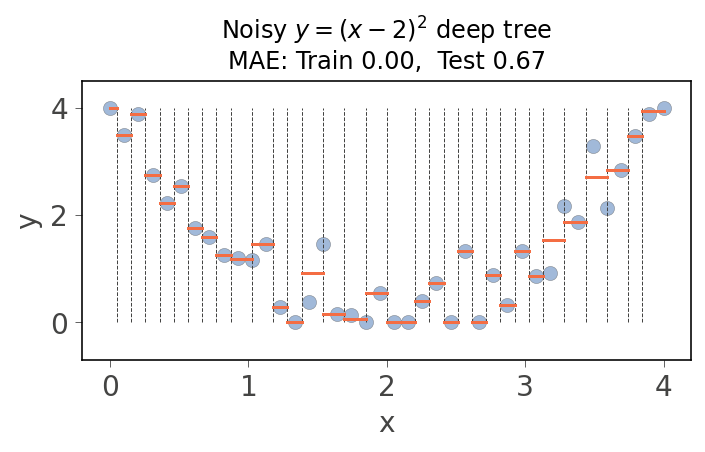

In [249]:
def plot_sample_regions(n=40):
    X,y = quad_data(n=n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    t = DecisionTreeRegressor()
    t.fit(X_train,y_train)

    fig, ax = plt.subplots(1,1, figsize=(5,3.3))
    rtreeviz_univar(t, X, y, 'x', 'y', ax=ax, show={'splits'},
                    markersize=50, mean_linewidth=1.5)
    y_pred_train = t.predict(X_train)
    y_pred_test = t.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    ax.set_title(f"Noisy $y=(x-2)^2$ deep tree\nMAE: Train {mae_train:.2f},  Test {mae_test:.2f}")
    ax.set_ylim(-.7,4.5)
    plt.tight_layout()

plot_sample_regions()

It's off by like 0.46 MAE, which is a lot because that's a good portion of the overall y range of 0..4.

### Animate different partitionings

In [250]:
camera = pltvid.Capture()

for i in range(5):
    plot_sample_regions()
    camera.snap()
    
camera.save("/Users/parrt/Desktop/syn.gif", duration=750)

### Animate aggregation of multiple samples

In [263]:
camera = pltvid.Capture()

for i in range(5): # bootstrap another sample
    X,y = quad_data()
    fig,ax = plt.subplots(1,1,figsize=(4,2.5))
    ax.scatter(X,y,s=20,c='#ABD9E9',edgecolors=GREY,lw=.35)
    #ax.plot(X,y,c='#73ADD2',lw=.5)
    camera.snap()
    
camera.save("/Users/parrt/Desktop/syn-aggr.gif", duration=750)

In [307]:
camera = pltvid.Capture(dpi=300)

n=40
for nsamples in [1,2,3]+[*range(4,30+1,2)]:
    fig,ax = plt.subplots(1,1,figsize=(3.8,2.5))
    y_avg = np.zeros(shape=(n,1))
    for i in range(nsamples):
        X,y = quad_data(n=n)
        y_avg += y
        ax.plot(X,y,c='#73ADD2',lw=.5)

    y_avg /= nsamples
    ax.plot(X,y_avg,c='#D73028',lw=1)
    ax.set_title(f"{nsamples} bagged regression trees")
    if nsamples>=15:
        camera.snap(3)
    else:
        camera.snap()
    
camera.save("/Users/parrt/Desktop/syn-aggr.gif", duration=1000)

## Wine data partitioning animation; overfitting

In [319]:
wine = load_wine()
X = wine.data[:,[12,6]] # ['proline','flavanoid']
y = wine.target
X.shape

(178, 2)

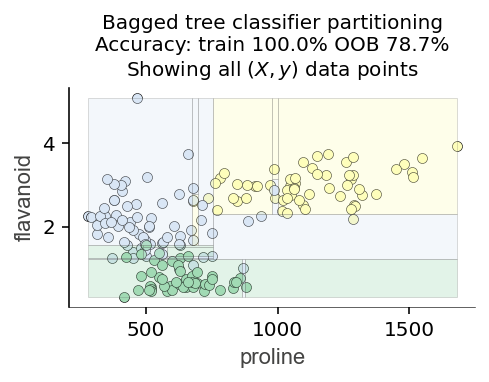

In [385]:
# bootstrap a subsample to simulate different identically-distributed datasets

def plot_bagged_tree(X,y):
    n = len(y)
    idx = np.random.randint(0,n,size=n) 
    X_train = X[idx]
    y_train = y[idx]
    # get OOB samples
    mask = np.ones(n, dtype=bool)
    mask[idx] = False
    X_test = X[mask]
    y_test = y[mask]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    accur_train = dt.score(X_train, y_train)
    accur_oob = dt.score(X_test, y_test)

    figsize = (3.5,2.8)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ct = ctreeviz_bivar(dt, X, y, # plot original points not bootstrap
                         feature_names = ['proline','flavanoid'], 
                         target_name='wine',
                         show={'splits'},
                         colors={'scatter_edge': 'black'},
                        fontsize=11,
                        ax=ax
                       )
    ax.set_title(f"Bagged tree classifier partitioning\nAccuracy: train {accur_train*100:.1f}% OOB {accur_oob*100:.1f}%\nShowing all ($X,y$) data points",
                fontsize=10)
    plt.tight_layout()
    
plot_bagged_tree(X,y)

In [387]:
camera = pltvid.Capture(dpi=300)
for i in range(7):
    plot_bagged_tree(X,y)
    camera.snap()
    
camera.save("/Users/parrt/Desktop/wine-bag.gif", duration=1000)